In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt  # For plotting losses
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths to your Google Drive folders (update the path as needed)
drive_folder = '/content/drive/MyDrive/pavan'  # replace with your drive folder path
results_folder = os.path.join(drive_folder, 'results')
models_folder = os.path.join(drive_folder, 'models')

os.makedirs(results_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)

Mounted at /content/drive


In [3]:

# Hyperparameters
batchSize = 64
imageSize = 64

# Creating the Transform
transform = transforms.Compose([
    transforms.Resize(imageSize),  # Scaling the image to a 64*64
    transforms.ToTensor(),  # Converting to PyTorch Tensor ; changing from (H,W,C) to (C,H,W) ; Normalizing values to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # (mean,std). changes values to [-1,1]. Stabilizes Training
])

dataset = dset.CIFAR10(root="./data", download=True, transform=transform)
# Using dataLoader to get the images of the training set batch by batch.
# A higher num_workers (>1) enables faster data loading by using multiple cores.

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # If using Nvidia GPU
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")  # If using Mac GPU
print(device)
# Lists to store losses
G_losses = []
D_losses = []

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
cuda


In [4]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)  # (mean, std)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)  # (mean = 1, std)
        m.bias.data.fill_(0)  # Bias initiated with 0

# Defining the Generator
class G(nn.Module):  # We introduce a class to define the generator.
    def __init__(self):  # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__()  # We inherit from the nn.Module tools.
        self.main = nn.Sequential(  # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),  # We start with an inversed convolution. (in channels, out channels, kernel size, stride, padding) Bias is False as we are doing batch normalization in next step
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # We start with an inversed convolution. (in channels, out channels, kernel size, stride, padding) Bias is False as we are doing batch normalization in next step
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # We start with an inversed convolution. (in channels, out channels, kernel size, stride, padding) Bias is False as we are doing batch normalization in next step
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # We start with an inversed convolution. (in channels, out channels, kernel size, stride, padding) Bias is False as we are doing batch normalization in next step
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # We start with an inversed convolution. (in channels, out channels, kernel size, stride, padding) Bias is False as we are doing batch normalization in next step
            nn.Tanh()  # We apply a Tanh rectification to break the linearity and stay between -1 and +1 which is how the discriminator will again take in the values
        )

    def forward(self, input):  # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input)  # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output  # We return the output containing the generated images.

# Creating the Generator
netG = G().to(device)  # We create the generator object.
netG.apply(weights_init)  # We initialize all the weights of its neural network.

# Defining the Discriminator
class D(nn.Module):  # We introduce the __init__() function that will define the architecture of the discriminator.
    def __init__(self):  # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__()  # We inherit from the nn.Module tools.
        self.main = nn.Sequential(  # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # Starting with Convolution network as the input is an image
            nn.LeakyReLU(0.2, inplace=True),  # Helps gradient flow (avoids dead neurons). inplace True since we don't need a new Tensor
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

# Creating the Discriminator
netD = D().to(device)
netD.apply(weights_init)


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Streaming output truncated to the last 5000 lines.
[93/100][474/782] Loss_D: 0.5149 Loss_G: 6.3514
[93/100][475/782] Loss_D: 0.1055 Loss_G: 6.2360
[93/100][476/782] Loss_D: 0.6442 Loss_G: 1.4610
[93/100][477/782] Loss_D: 1.1251 Loss_G: 8.7929
[93/100][478/782] Loss_D: 1.5671 Loss_G: 1.1014
[93/100][479/782] Loss_D: 0.8867 Loss_G: 5.7907
[93/100][480/782] Loss_D: 0.3243 Loss_G: 5.3012
[93/100][481/782] Loss_D: 0.0808 Loss_G: 5.1437
[93/100][482/782] Loss_D: 0.2104 Loss_G: 4.1450
[93/100][483/782] Loss_D: 0.2463 Loss_G: 3.7082
[93/100][484/782] Loss_D: 0.5463 Loss_G: 6.5246
[93/100][485/782] Loss_D: 0.5019 Loss_G: 4.1082
[93/100][486/782] Loss_D: 0.1608 Loss_G: 3.0675
[93/100][487/782] Loss_D: 0.3051 Loss_G: 5.1841
[93/100][488/782] Loss_D: 0.1914 Loss_G: 5.1041
[93/100][489/782] Loss_D: 0.1353 Loss_G: 4.9323
[93/100][490/782] Loss_D: 0.2232 Loss_G: 3.1497
[93/100][491/782] Loss_D: 0.4536 Loss_G: 5.4051
[93/100][492/782] Loss_D: 0.2781 Loss_G: 4.3146
[93/100][493/782] Loss_D: 0.1435 Loss

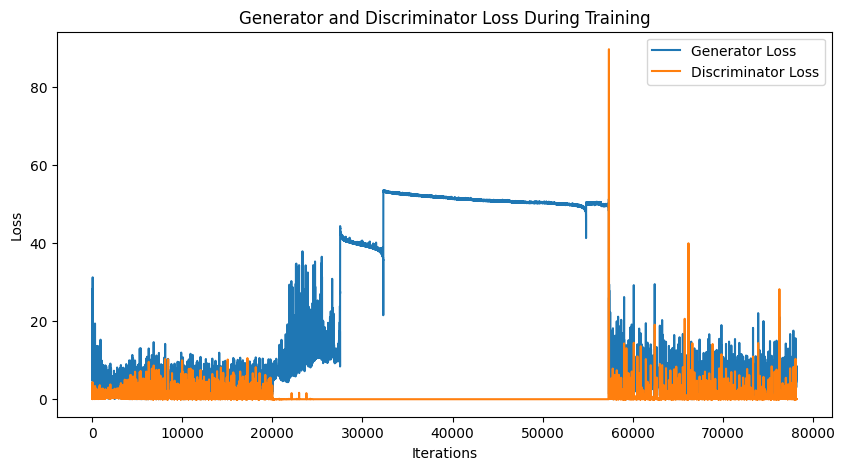

In [5]:
# Training the DC-GANs
criterion = nn.BCELoss()  # We create a Binary Cross Entropy criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))  # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))  # We create the optimizer object of the Generator.

epochs = 100
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):  # Iterate over the images of the dataset
        # 1st Step: Updating the weights of the Discriminator and Generator
        netD.zero_grad()  # Important: We initialize to 0 the gradients of the discriminator with respect to the weights.

        # Train the Discriminator with some real images of the dataset
        real, _ = data  # We get a real image of the dataset which will be used to train the discriminator.
        real = real.to(device)
        target = torch.ones(real.size()[0], device=device)  # We get the target.
        output = netD(real)  # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target)  # We compute the loss between the predictions (output) and the target (equal to 1).

        # Train the Discriminator with some fake images
        noise = torch.randn(real.size()[0], 100, 1, 1, device=device)  # We make a random input vector (noise - normal distributed) [called latent vector] of the generator.
        target = torch.zeros(real.size()[0], device=device)
        fake = netG(noise)  # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        output = netD(fake.detach())  # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target)  # We compute the loss between the prediction (output) and the target (equal to 0).

        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()  # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step()  # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()  # Important: We initialize to 0 the gradients of the generator with respect to the weights.

        output = netD(fake)  # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        target = torch.ones(real.size()[0], device=device)
        errG = criterion(output, target)  # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward()  # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step()  # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.

        # Append losses to lists
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Print losses and save sample images every 100 iterations
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, epochs, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real.cpu(), f'{results_folder}/real_samples.png', normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.detach().cpu(), f'{results_folder}/fake_samples_epoch_{epoch:03d}.png', normalize=True)

    # Save the models every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'lossG': errG.item(),
            'lossD': errD.item(),
        }, f'{models_folder}/checkpoint_epoch_{epoch}.pth')

# Plot and save the loss curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'{results_folder}/loss_plot.png')
plt.show()
